<a href="https://colab.research.google.com/github/ugolbck/CNN-code-mixed-sentiment/blob/master/convolutional_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhanced convolutional NN for code-mixed sentiment analysis

# Data loading

We load the data from a conll-formatted file and extract all tweets and their sentiment polarity.

"#meta= 1 positive

word1 lang1

word2 lang1

word3 lang2

word4 other"

In [0]:
!pip install conllu
# !pip install matplotlib==3.1.0 # In case bugged version that outputs cut confusion matrices
from conllu import parse
from numpy import asarray, zeros, array, unique

data_path = '/content/drive/My Drive/RD/backup_train_conll_spanglish.txt'

with open(data_path, "r") as in_file:
    data = in_file.read()
    
sentences = parse(data, fields=["form", "tag"], \
metadata_parsers={"meta": lambda key, value: (key, value.split("\t"))})

# Pre-processing

We clean the data, use the TweetTokenizer from NLTK to tokenize and remove usernames. We remove URLs and add hashtags that had a dummy form in the original file

In [0]:
import nltk
nltk.download('stopwords')

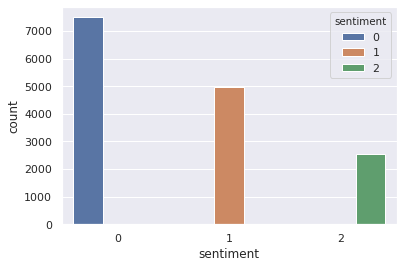

In [0]:
import re
from nltk.tokenize import casual_tokenize
from nltk.corpus import stopwords
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import seaborn as sns
import pandas as pd

tools = ['tweet_tokenize',
         'url_remove',
         ]

whitelist = {'no', "doesn't", 'nor', 'couldn', "won't", "wouldn't", 'very', "you're", "isn't", 'off', 'why', 'muy', 'muchos', 'todo', 'poco',}

patterns = {
    'urls': '\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*',
}

stopwords = (set(stopwords.words('english')) | set(stopwords.words('spanish')) | {'ke'}) - whitelist

# Pre-process raw data and insert in numpy arrays
### TO OPTIMIZE / DO IN OTHER FILE ###
X, y, y_tmp = [], [], []
for i in range(len(sentences)):
    phrase = ''
    for word in sentences[i]:
        if word['form'].lower() in stopwords:
            pass
        else:
            phrase += ' ' + word["form"] if len(phrase) != 0 else word["form"]
    if 'tweet_tokenize' in tools:
        # Adapted tokenization, removes usernames and shortens character repetitions
        phrase = ' '.join(casual_tokenize(phrase, reduce_len=True, strip_handles=True))
    if 'url_remove' in tools:
        phrase = re.sub(re.compile(patterns['urls']), "", phrase)
    X.append(phrase)
    y_tmp.append(sentences[i].metadata["meta"][1])
    
for i in y_tmp:
    if i == 'positive':
        y.append(0)
    elif i == 'neutral':
        y.append(1)
    else:
        y.append(2)

# Ploting the categorical distribution
df = pd.DataFrame()
df["tweet"] = X
df["sentiment"] = y
sns.set(style="darkgrid")
sns.countplot(x='sentiment', data=df, hue='sentiment')

# Computing the class weight penalties
class_weights = class_weight.compute_class_weight('balanced', unique(y), y)
#We need the class weights to be a dictionary
class_weights = dict(enumerate(class_weights))

# Multi-label classification
y = to_categorical(y, 3)
X = asarray(X)

# Splitting the data sets
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Embedding

Helper function to create character embedding inputs. We start by creating a nested list of zeros, each representing a character in the sentence (+ padding until the maximum sentence/word length). Then we replace zeros with their corresponding index in the keras tokenizer object.

This function is an equivalent to texts_to_sequences() + pad_sequences().

In [0]:
def toCharInput(sentences, tokenizer, s_len, w_len):
    """
    Converts a list of sentences into character input
    with dimensions (batch_size, word_vocab, char_vocab)

    :param sentences: list of strings
    :param tokenizer: Tokenizer object fitted on train data
    :param s_len: longest possible sentence size
    :param w_len: longest possible word size

    :return char_input: post-padded character-based input for character embedding layer
    """
    sentences_len = len(sentences)

    # 3-dimentional matrix where each 0 is a character in a word in a sentence
    char_input = [[[0] * w_len for _ in range(s_len)] for _ in range(sentences_len)]

    for sentence_i, sentence in enumerate(sentences):
        for word_i, word in enumerate(sentence):
            if word_i >= s_len:
                break
            for char_i, char in enumerate(word):
                if char_i >= w_len:
                    break
                char_input[sentence_i][word_i][char_i] = tokenizer.word_index.get(char)

    return asarray(char_input)

Build word and character inputs, get the size of word and character vocabularies.

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

s_length = 100
w_length = 50
filters = '"$%&*+,-./<=>[\\]`°{|}~\t\n'

# Tokenizer objects 
word_tokenizer = Tokenizer(num_words=10000, filters=filters, lower=True, char_level=False)
char_tokenizer = Tokenizer(num_words=10000, char_level=True, lower=False)

# Adapt to the training data
word_tokenizer.fit_on_texts(X_train)
char_tokenizer.fit_on_texts(X_train)

# Creating inputs for the character embedding layer
C_train = toCharInput(X_train, char_tokenizer, s_length, w_length)
C_test = toCharInput(X_test, char_tokenizer, s_length, w_length)

# Each word becomes its index from the word->index frequency dictionary
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

# Get word/character vocabulary sizes
word_vocab_size = len(word_tokenizer.word_index) + 1
char_vocab_size = len(char_tokenizer.word_index) + 1

# Add zeros to sequences until max sentence length
X_train = pad_sequences(X_train, padding='post', maxlen=s_length)
X_test = pad_sequences(X_test, padding='post', maxlen=s_length)

Load GloVe or fastText word embeddings.

In [0]:
##### DO NOT RERUN THIS CELL #####

from itertools import islice

es_embd = '/content/drive/My Drive/RD/wiki.es.align.vec'
en_embd = '/content/drive/My Drive/RD/wiki.en.align.vec'
glove = '/content/drive/My Drive/RD/glove.twitter.27B.200d.txt'

EMBD = 'glove'

def load_words(embd_filepath):
    embd_dict = dict()
    with open(embd_filepath, encoding="utf8") as emb_file:
        for line in islice(emb_file, 1, None):
            records = line.split(' ')
            word = records[0]
            vector = asarray(records[1:], dtype='float32')            
            embd_dict[word] = vector
    return embd_dict

if EMBD == 'fasttext':
    embd_dict = load_words(en_embd)
    words_es = load_words(es_embd)

    # Dealing with words that are in both embeddings by averaging their vectors
    for k, v in words_es.items():
        if k in embd_dict.keys():
            embd_dict[k] = [(x+y)/2 for x,y in zip(*[v, embd_dict[k]])]
        else:
            embd_dict[k] = v
elif EMBD == 'glove':
    embd_dict = load_words(glove)
else:
    raise ValueError("Wrong embedding name.")

In [0]:
# Creation of the word embedding
word_embedding = zeros((word_vocab_size, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embd_dict.get(word)
    if embedding_vector is not None:
        word_embedding[index] = embedding_vector

We print the rate of words in our vocabulary that are present in the embedding matrix.

In [0]:
from numpy import count_nonzero

rate = (count_nonzero(count_nonzero(word_embedding, axis=1)) / word_vocab_size) * 100
print(str(rate) + "%", "of the vocabulary was found in the pre-trained embedding.")

82.47444081166641% of the vocabulary was found in the pre-trained embedding.


# Embedding layer

Concatenation of pre-trained word Embeddings (GloVe) and randomly initialized character embeddings.

In [0]:
def embd_layer(vocab_word_size,
               vocab_char_size,
               word_embd_dim,
               char_embd_dim,
               word_embd_weights,
               char_embd_weights = None,
               word_embd_trainable = False,
               char_embd_trainable = True,
               max_word_len = None,
               char_hidden_type = 'lstm',
               char_hidden_dim = 25):
    """
    Returns both inputs and the embedding layer
    """
    
    word_input_layer = Input(shape=(None,), name='Input_Word')
    
    char_input_layer = Input(shape=(None, max_word_len), name='Input_Char')
    
    word_embd_layer = Embedding(
        input_dim=vocab_word_size,
        output_dim=word_embd_dim,
        weights=word_embd_weights,
        trainable=word_embd_trainable,
        name='Embedding_Word',
    )(word_input_layer)
    
    char_embd_layer = Embedding(
        input_dim=vocab_char_size,
        output_dim=char_embd_dim,
        weights=char_embd_weights,
        embeddings_initializer='random_uniform',
        trainable=char_embd_trainable,
        name='Embedding_Char_Pre',
    )(char_input_layer)
    
    char_hidden_layer = Bidirectional(LSTM(
                units=char_hidden_dim,
                input_shape=(max_word_len, vocab_char_size),
                return_sequences=False,
                return_state=False))
    
    char_embd_layer = TimeDistributed(layer=char_hidden_layer, name='Embedding_Char_Final',)(char_embd_layer)
    
    embd_layer = Concatenate(name='Embedding',)([word_embd_layer, char_embd_layer])
    
    return [word_input_layer, char_input_layer], embd_layer

# Model

Building the neural network. 

In [0]:
from keras.models import Model
from keras.layers.core import Dropout, Dense
from keras.layers import Input, TimeDistributed, LSTM, Bidirectional, Concatenate
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.optimizers import Adam
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

""" Parameters """
joint_embd = True
h_dropout = 0.5
l2_reg = 0.001
epochs = 30
batch_size = 64
lr = 0.0001
val_size = 0.15
dense_units = 32

# Joint word and character embedding
if joint_embd:
    inputs, embedding_layer = embd_layer(word_vocab_size, char_vocab_size, 300, 50,
                                        [word_embedding], max_word_len=w_length,
                                            word_embd_trainable=False)
else:
    # Input
    inputs = Input(shape=(None,), name='Input')

    # Embedding
    embedding_layer = Embedding(word_vocab_size, 300, weights=[word_embedding],
                                input_length=s_length, trainable=False)(inputs)

# Convolution
convo_layer_1 = Conv1D(64, 3, activation='relu', name='Convolution_1', kernel_regularizer=l2(l2_reg))(embedding_layer)
pooling_layer_1 = GlobalMaxPooling1D(name='Pooling_1')(convo_layer_1)

# Activation
dropout_layer = (Dropout(h_dropout))(pooling_layer_1)
dense_layer = Dense(dense_units, activation='relu', name='Fully_conn', kernel_regularizer=l2(l2_reg))(dropout_layer)
dropout_layer = (Dropout(h_dropout))(dense_layer)

# Classification
dense_layer = Dense(3, activation='softmax', name='Dense_classification')(dropout_layer)

# Model
model = Model(inputs=inputs, outputs=dense_layer)

model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['acc'])

Training the model with early stopping to speed up the process in case the model doesn't improve, and class weights to counter 

In [0]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose=1)

history = model.fit([X_train, C_train],
                    y_train, batch_size=batch_size,
                    epochs=epochs, validation_split=val_size,
                    verbose=1, callbacks=[early_stop], class_weight=class_weights)

# Evaluation

Keras metrics are not reliable as they measure the average accuracy. As we deal with multilabel classification

scikit evaluation on test set...
Accuracy: 0.508
Precision: 0.5366232110758202
Recall: 0.508
F1 Score: 0.5128553160523172
Keras evaluation on test set...
1500/1500 [==============================] - 4s 3ms/step
[1.0353015298843384, 0.5079999996821085]


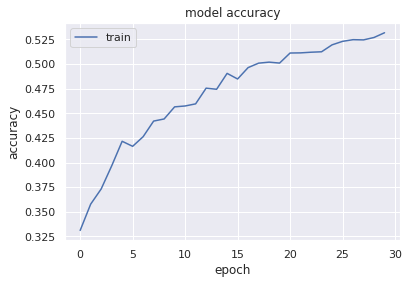

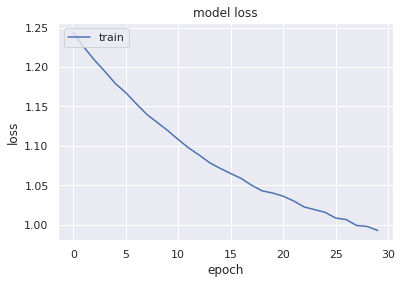

In [0]:
from numpy import argmax
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

y_pred = model.predict([X_test, C_test])
y_gold = [argmax(i) for i in y_test]
y_scores = [argmax(i) for i in y_pred]

print("scikit evaluation on test set...")
print("Accuracy: " + str(accuracy_score(y_gold, y_scores)))
print("Precision: " + str(precision_score(y_gold, y_scores, average='weighted')))
print("Recall: " + str(recall_score(y_gold, y_scores, average='weighted')))
print("F1 Score: " + str(f1_score(y_gold, y_scores, average='weighted')))

print("Keras evaluation on test set...")
results = model.evaluate([X_test, C_test], y_test)
print(results)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

# Confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(None)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.savefig('/content/drive/My Drive/RD/CNNenhanced.png', bbox_inches='tight', quality=50)

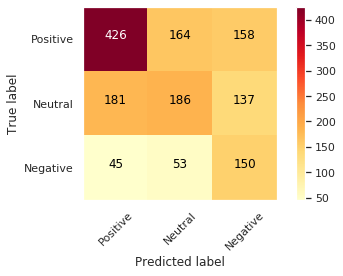

In [0]:
cnf_matrix = confusion_matrix(y_gold, y_scores, labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive', 'Neutral', 'Negative'], title='')

# Logs

I choose to keep track of global model parameters, but it is also possible to use the Callback() class from keras to produce per-epoch logs of loss and accuracy.

These logs are directly appended to a text file located on the Drive.

In [0]:
import datetime

version = '1.3.2 - 1 convolution, 2 dense with dropout between the 2. fasttext + class weights + charEmbd'
log_hyperparam = {
    "validation": val_size,
    "s_length": s_length,
    "w_length": w_length,
    "epochs": epochs,
    "batch": batch_size,
    "hidden_dropout": h_dropout,
    "L2": l2_reg,
    "l_rate": lr,
}

log_filepath = '/content/drive/My Drive/RD/results_log.txt'

print("Writing logs...")
with open(log_filepath, "a+") as out_file:
    out_file.write(8*"#" + str(datetime.datetime.now()) + 8*"#" + "\n")
    out_file.write("Model version:" + version + "\n")
    out_file.write(str(log_hyperparam) + "\n")
    out_file.write("Train accuracy" + str(["%.3f" %a for a in history.history['acc']]) + "\n")
    out_file.write("Val accuracy" + str(["%.3f" %a for a in history.history['val_acc']]) + "\n")
    out_file.write("Train loss" + str(["%.3f" %a for a in history.history['loss']]) + "\n")
    out_file.write("Val loss" + str(["%.3f" %a for a in history.history['val_loss']]) + "\n")
    out_file.write("Keras test metrics: " + str(results) + "\n")
    out_file.write("\n")
print("Done.")